## Density Estimation Precise Data Set
Author: Clara Hoffmann

Estimate density for the training data $\{y_i\}_{i=1}^n$ in order to transform all $\{y_i\}_{i=1}^n$ to $z_i = \Phi_1^{-1}(F_y(y_i))$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
from scipy import integrate
from scipy import stats
import statsmodels.api as sm
import math
import seaborn as sns
import multiprocessing
from helpers import find_closest_element, Fy

In [2]:
# read in df with steering angles
df = pd.read_csv('../../../data/commaai/training_files_filtered/indices/train_indices.csv')
df = df.loc[df['use'] == 1, :]
df.columns = ['id', 'filename', 'use', 'angle', 'filenumber']
df = df.loc[abs(df['angle']) < 60]

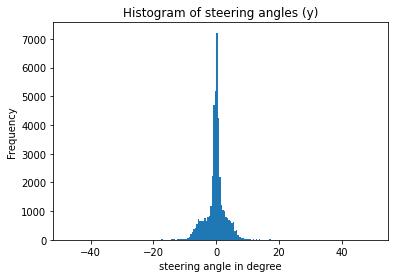

In [3]:
plt.hist(df['angle'], bins = 200)
plt.title('Histogram of steering angles (y)')
plt.xlabel('steering angle in degree')
plt.ylabel('Frequency')
plt.savefig('histogram_y.png')

## 1. Estimate CDF $F_y$

In [4]:
# Estimate densities
kde = sm.nonparametric.KDEUnivariate(df['angle'])
kde.fit() # Estimate the densities
support = kde.support
endog = kde.endog
density = kde.density
grid = np.array([i for i in range(0, support.shape[0])])

# Estimate CDF
def f_integral(i):
    return(integrate.trapz(density[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as p:
    probs = p.map(f_integral, grid)
cdf = np.cumsum(np.array(probs))

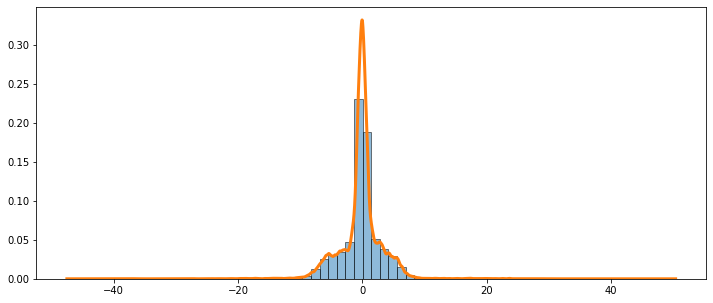

In [5]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(df['angle'], bins=70, density=True, label='Histogram from samples',
        zorder=5, edgecolor='k', alpha=0.5)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label='KDE from samples', zorder=10)

## 2. Check Normality Assumption of $z_i = \Phi_1^{-1}(F_y(y_i))$.

In [6]:
# transform y to z
density = pd.DataFrame({'axes': kde.support , 'pdf': kde.density, 'cdf': cdf })
tqdm.pandas()
df['tr_angle2'] = df['angle'].progress_apply(lambda x: norm.ppf(Fy(x, density)))
df['tr_angle2'] = np.array(df['tr_angle2'] , dtype=float)

/home/hofmancl/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 43736/43736 [00:21<00:00, 1996.82it/s]


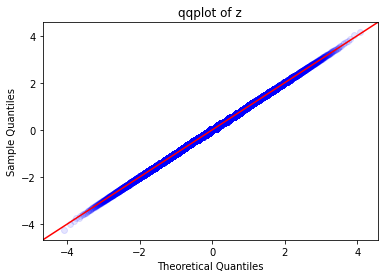

In [7]:
# qqplot to check normality
fig = sm.qqplot(df.loc[:,'tr_angle2'], stats.norm, fit=True, line="45")
dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')
[d.set_alpha(0.1) for d in dots]
plt.title('qqplot of z')
plt.savefig('qqplot_transformed_values.png')

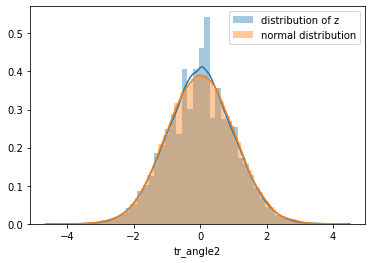

In [8]:
# histogram to check normality
value = np.random.normal(loc=0,scale=1,size=df['tr_angle2'].shape[0])
f, ax = plt.subplots(1, 1)
sns.distplot(df['tr_angle2'], label = 'distribution of z')
sns.distplot(value, label = 'normal distribution')
ax.legend()
f.savefig('histogram_z_vs_normal_distr.png')

In [9]:
# kolmogorov smirnhoff test for normality
k2, p = stats.kstest(df['tr_angle2'], 'norm')
p

8.999602296426351e-26

## 3. Save

In [ ]:
# save density if everything is ok
#density.to_csv('../../../data/commaai/density/gaussian_density_filtered.csv', index=False)